In [1]:
import matplotlib.font_manager as font_manager
from matplotlib.lines import Line2D
import matplotlib as mpl
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import os
from scipy.stats import bootstrap
import statsmodels.api as sm
import statsmodels.formula.api as smf

params = {
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "font.size": 12,
    "legend.fontsize": 12,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "text.usetex": False,
}

mpl.rcParams.update(params)


import warnings

warnings.filterwarnings("ignore")


In [2]:
df_time_series = pd.read_csv(
    "./data/df_timeseries_en.tsv.gz", compression="infer", sep="\t"
)
df_time_series["datetime"] = pd.to_datetime(df_time_series["datetime"])

df_channels = pd.read_csv("./data/df_channels_en.tsv.gz", compression="infer", sep="\t")
df_channels["join_date"] = pd.to_datetime(df_channels["join_date"])


In [ ]:
video_metadatas = pd.read_feather(
    "./data/yt_metadata_helper.feather",
    columns=[
        "categories",
        "upload_date",
        "duration", 
        "like_count",
        "dislike_count",
        "view_count",
        "channel_id",
    ],
)


In [ ]:
# round the subs value, easier to consider 1 sub as a person and not half of a person...
df_time_series.subs = df_time_series.subs.round(0)


In [ ]:
df_time_series.head()


In [ ]:
df_channels.head()


In [ ]:
video_metadatas.head()


# Check length of videos

An idea would be to use cut to match length of videos into discrete intervals 

In [ ]:
video_metadatas.duration.describe()


In [ ]:
# To make it easier to grasp the length of videos, we will convert the lengths to minutes at first...
video_metadatas["duration_min"] = video_metadatas["duration"] / 60
video_metadatas.duration_min.describe()


In [ ]:
plt.boxplot(video_metadatas["duration_min"], showfliers=False, vert=False)
plt.title("Duration of Videos in Minutes")


In [ ]:
duration_min_cumul = plt.hist(
    video_metadatas.duration_min, bins=100, log=True, cumulative=-1, histtype="step"
)
plt.title("Histogram of Duration for YouTube Videos (cumulative)")
plt.ylabel("# of Videos (in log scale)")
plt.xlabel("Duration in Minutes")
plt.xticks(rotation=30, ha="right")
plt.show()


In [ ]:
plt.loglog(duration_min_cumul[1][1:], duration_min_cumul[0])
plt.title("Histogram of Duration for YouTube Videos (cumulative)")
plt.ylabel("# of Videos (in log scale)")
plt.xlabel("Duration")
plt.xticks(rotation=30, ha="right")
plt.show()


In [ ]:
# long to compute

# bucket_durations = pd.cut(video_metadatas['duration'], bins=100)
# print(type(bucket_durations))


---

# Check frequency of videos

In [ ]:
video_count = (
    video_metadatas.groupby(pd.Grouper(key="upload_date", freq="W")).count().channel_id
)


In [ ]:
plt.plot(video_count, color="#7570b3", ls="--", label="\% videos uploaded")
plt.yscale("log")
plt.ylabel("Number of Videos")
plt.xlabel("Time")
plt.title("Number of videos updated each week")


In [ ]:
# now we will determine how many videos are uploaded to YouTube by each channel by year
video_metadatas["yearNumber"] = video_metadatas["upload_date"].dt.year
vd_cnt_by_id_yr = (
    video_metadatas.groupby(["channel_id", "yearNumber"])
    .count()
    .categories.unstack()
    .reset_index()
)
vd_cnt_by_id_yr.columns.name = None


In [ ]:
# we now remove the channels that uploaded less than 12 videos throughout the study period
vd_cnt_by_id_yr_filtered = vd_cnt_by_id_yr[vd_cnt_by_id_yr.sum(axis=1) > 12]


In [ ]:
vd_cnt_by_id_yr_filtered_summary = vd_cnt_by_id_yr_filtered.describe()


In [ ]:
plt.fill_between(
    x=list(vd_cnt_by_id_yr_filtered_summary.columns.values),
    y1=list(vd_cnt_by_id_yr_filtered_summary.loc["25%", :]),
    y2=list(vd_cnt_by_id_yr_filtered_summary.loc["75%", :]),
    alpha=0.5,
    color="gray",
)
plt.plot(vd_cnt_by_id_yr_filtered_summary.loc["50%", :], color="black")

plt.xlabel("Year")
plt.ylabel("Yearly Upload Frequency")
plt.title("The quantiles of yearly video upload frequency")
# here we choose quantiles, since mean would be significantly affected by the extremely high yearly upload rates


# Weekday Analysis

In [ ]:
video_metadatas["weekNumber"] = video_metadatas["upload_date"].dt.weekday
vd_cnt_by_id_wk = (
    video_metadatas.groupby(["channel_id", "weekNumber", "yearNumber"])
    .count()
    .categories.unstack()
    .reset_index()
)
vd_cnt_by_id_wk.columns.name = None


In [ ]:
vd_cnt_by_id_wk["mean_upload"] = vd_cnt_by_id_wk.iloc[:, 2:].mean(axis=1, skipna=True)


In [ ]:
ax = sns.boxplot(
    x="weekNumber", y="mean_upload", data=vd_cnt_by_id_wk, showfliers=False
)


In [ ]:
vd_cnt_by_wk = (
    video_metadatas.groupby(["weekNumber", "yearNumber"])
    .count()
    .categories.unstack()
    .reset_index()
)
vd_cnt_by_wk.columns.name = None


In [ ]:
vd_cnt_by_wk_norm = vd_cnt_by_wk.iloc[:, 2:] / vd_cnt_by_wk.iloc[:, 2:].sum(skipna=True)


In [ ]:
plt.rcParams["figure.figsize"] = (15, 10)
plt.plot(vd_cnt_by_wk_norm.T)
plt.legend(
    ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
)
plt.xlabel("year")
plt.ylabel("NORMALISED: video uploaded each weekday")
plt.title("NORMALISED: The evolution of video upload rate for each weekday")
plt.show()


In [ ]:
# it seems that weekday is definitely prefered over weekends, whereas which day of the week doesn't seem to matter too much.


---

# How long to reach 1M subscribers 

Could be interesting to take all the videos with 10K, 20K, 30K, ... and see the evolution to reach 100K for example. And compare different evolution : from 50K to 100K or from 500K to 600K, etc.. which one is the fastest, easiest ?  

In [ ]:
def get_df_channel_ascension(start_subs, end_subs):
    """finds the channels in the time series that have less than the start_subs and more than end_subs.
    It means that it begins with less than start_subs and have now at least end_subs

    Args:
        start_subs (float): low_threshold
        end_subs (float): high_threshold

    Returns:
        dataframe containing all the channels with evolution from starts_subs to end_subs
    """
    under_start_subs = df_time_series[df_time_series["subs"] < start_subs]
    more_end_subs = df_time_series[df_time_series["subs"] > end_subs]
    channel_start_to_end = df_time_series[
        df_time_series.channel.isin(under_start_subs.channel)
        & df_time_series.channel.isin(more_end_subs.channel)
    ]
    return channel_start_to_end


In [ ]:
def get_mean_time_to_reach_X_subs(df, lower_bound, upper_bound):
    time_to_reach_X_subs = df.groupby("channel").apply(
        lambda group: pd.Series(
            {
                "from_zero_to_hero_duration": group[group.subs > upper_bound][
                    "datetime"
                ].iloc[0]
                - group[group.subs < lower_bound]["datetime"].iloc[-1]
            }
        )
    )
    return time_to_reach_X_subs


In [ ]:
channel_10K_to_1M = get_df_channel_ascension(10_000, 1_000_000)
print(
    "We have {} channels that begins with 10K subs and reach at least 1M".format(
        channel_10K_to_1M.channel.nunique()
    )
)


In [ ]:
first_channel = channel_10K_to_1M.iloc[0]
test = channel_10K_to_1M[channel_10K_to_1M["channel"] == first_channel.channel]
# test = test[(test['datetime'] > np.datetime64('2018-07-20')) & (test['datetime'] < np.datetime64('2019-01-20'))]
test.plot(x="datetime", y="subs")
print("There are {} weeks for this channel".format(test.shape[0]))
print(
    "We should have approximately the same value : \n{} and {}".format(
        7 * test.shape[0], test.iloc[-1].datetime - test.iloc[0].datetime
    )
)


In [ ]:
# get the time it takes to go from less than 10K to 1M
time_to_reach_1M = get_mean_time_to_reach_X_subs(channel_10K_to_1M, 10_000, 1_000_000)
time_to_reach_1M.head()


In [ ]:
print(
    "In average YTbers take {} days to reach 1M of subscribers".format(
        time_to_reach_1M["from_zero_to_hero_duration"].mean().days
    )
)


It would be nice to bootstrap this result to see with interval of confidence the time taken by Youtuber to reach 1M

In [ ]:
data = time_to_reach_1M["from_zero_to_hero_duration"].apply(
    lambda delta_time: delta_time.days
)


In [ ]:
rng = np.random.default_rng()
conf_interval_reach_1M = bootstrap(
    (data,),
    np.mean,
    confidence_level=0.95,
    random_state=rng,
).confidence_interval
conf_interval_reach_1M


In [ ]:
print(
    "The 95% interval of confidence, the time taken to reach 1M (from 10K) is [{}, {}]".format(
        conf_interval_reach_1M.low, conf_interval_reach_1M.high
    )
)


---

# Check the number of views (maybe after we could add likes, dislike) given a certain categories and date of videos

For this task lets analyze and after ploting and getting some intuition, use logistic regression to 'predict' the nb of views given category and date 

In [ ]:
video_metadatas.head()
video_metadatas.shape


In [ ]:
# I added this [:] to make a copy of the video_metadatas, so that the following operation wont affect the original video_metadatas
videos_with_cat = video_metadatas[:]
# here I tried to use the same expression as the replace you used below but it doesnt seem to work...
videos_with_cat["categories"] = videos_with_cat["categories"].apply(
    lambda x: x.replace(" & ", "_")
)
# delete the rows with empty categories
videos_with_cat.categories.replace("", np.nan, inplace=True)
videos_with_cat.dropna(subset=["categories"], inplace=True)
videos_with_cat.shape


In [ ]:
videos_with_cat['yearNumber'] = videos_with_cat.upload_date.dt.year

In [ ]:
encoded_cat = pd.get_dummies(videos_with_cat.categories)
video_metadatas_encoded = videos_with_cat.join(encoded_cat)


In [ ]:
video_metadatas_encoded["year"] = video_metadatas_encoded["upload_date"].dt.year


In [ ]:
mean_views = video_metadatas_encoded.groupby(["year", "categories"]).apply(
    lambda x: pd.Series({"mean_view": x.view_count.mean()})
)


In [ ]:
mean_views[:10]


In [ ]:
# see the top most viewed categories every year
largest_cat_every_year = (
    mean_views.groupby("year")["mean_view"].nlargest(2).droplevel(0)
)
largest_cat_every_year[:10]


In [ ]:
# Alternatively, I suggest the following to determine which type of videos are more popular
# now we will determine how many videos are uploaded to YouTube by each channel by year
video_count_by_year = (
    videos_with_cat.dropna(axis=0).groupby(["categories", "yearNumber"]).sum()
)
# NOTE THAT CATEGORIES::MOVIES AND SHOWS HAVE VERY FEW DATA!


In [ ]:
video_view_count_by_year = video_count_by_year.view_count.unstack().reset_index()
video_view_count_by_year.columns.name = None

video_like_count_by_year = video_count_by_year.like_count.unstack().reset_index()
video_like_count_by_year.columns.name = None

video_dislike_count_by_year = video_count_by_year.dislike_count.unstack().reset_index()
video_dislike_count_by_year.columns.name = None


In [ ]:
videos_with_cat.loc[
    videos_with_cat["categories"] == "Movies",
]


In [ ]:
plt.rcParams["figure.figsize"] = (15, 10)
for i in np.arange(video_view_count_by_year.shape[0]):
    plt.plot(
        video_view_count_by_year.loc[
            i,
        ][2:],
        label=video_view_count_by_year.loc[i,][
            0:1
        ][0],
    )
plt.legend(loc="upper left")
plt.xlabel("year")
plt.ylabel("video view count")
plt.title("video view counts per year for each category")
plt.show()


In [ ]:
plt.rcParams["figure.figsize"] = (15, 10)
for i in np.arange(video_like_count_by_year.shape[0]):
    plt.plot(
        video_like_count_by_year.loc[
            i,
        ][2:],
        label=video_like_count_by_year.loc[i,][
            0:1
        ][0],
    )
plt.legend(loc="upper left")
plt.xlabel("year")
plt.ylabel("video likes count")
plt.title("video likes counts per year for each category")
plt.show()


In [ ]:
plt.rcParams["figure.figsize"] = (15, 10)
for i in np.arange(video_dislike_count_by_year.shape[0]):
    plt.plot(
        video_dislike_count_by_year.loc[
            i,
        ][2:],
        label=video_dislike_count_by_year.loc[i,][
            0:1
        ][0],
    )
plt.legend(loc="upper left")
plt.xlabel("year")
plt.ylabel("video dislikes count")
plt.title("video dislikes counts per year for each category")
plt.show()


In [ ]:
# NORMALISATION:
## 1. view count - normalise wrt. total video views per year, to see which categories is viewed more every year
plt.rcParams["figure.figsize"] = (15, 10)
for i in np.arange(video_view_count_by_year.shape[0]):
    plt.plot(
        video_view_count_by_year.loc[
            i,
        ][2:]
        / video_view_count_by_year.sum(axis=0)[2:],
        label=video_view_count_by_year.loc[i,][
            0:1
        ][0],
    )
plt.legend(loc="upper left")
plt.xlabel("year")
plt.ylabel("NORMALISED: video view count")
plt.title("NORMALISED: video view counts per year for each category")
plt.show()
# view on music videos decreases, whereas on entertainment and gaming increases


In [ ]:
## 2. like count - normalise wrt. total likes+dislikes for that category for that year
plt.rcParams["figure.figsize"] = (15, 10)
for i in np.arange(video_like_count_by_year.shape[0]):
    plt.plot(
        video_like_count_by_year.loc[
            i,
        ][2:]
        / (
            video_like_count_by_year.loc[
                i,
            ][2:]
            + video_dislike_count_by_year.loc[
                i,
            ][2:]
        ),
        label=video_like_count_by_year.loc[i,][
            0:1
        ][0],
    )
plt.legend(loc="upper left")
plt.xlabel("year")
plt.ylabel("NORMALISED: video likes count")
plt.title("NORMALISED: video likes counts per year for each category")
plt.show()

# now it is interesting to see that news_politics and education are consistantly less liked
# whereas for nonprofits_activism is becoming more loved


---

# Implement the # of views divided by the # of subs 

In [55]:
# use the time series dataframe to implement this, it would be easier. 
df_time_series['year'] = df_time_series.datetime.dt.year
df_time_series.sample(4)

,channel,category,datetime,views,delta_views,subs,delta_subs,videos,delta_videos,activity,year,views_over_subs
1255565,UCj56GATzRKv5aiyqq5pI2FA,People & Blogs,2016-08-08 00:00:00,1.242718e+07,896341.750,14049.500000,76.50,0,0,0,2016,11716.885621
8031961,UCb1lfdYKtYUlITz5sRZrjXg,Gaming,2019-06-24 01:00:00,1.356022e+07,0.000,188803.864583,1027.25,93,0,0,2019,0.000000
9345305,UCeJfZqIcyy1z3wySHq4iDDg,Entertainment,2016-08-08 00:00:00,3.965854e+05,7550.375,7220.750000,162.75,33,1,2,2016,46.392473
15564767,UCH1dpzjCEiGAt8CXkryhkZg,News & Politics,2019-07-15 00:00:00,3.807654e+07,93307.375,193327.500000,1389.50,738,8,19,2019,67.151763


In [59]:
# penalize the big channel (many subs) by dividing the number of delta views by nb of total subscribers
df_time_series['views_over_subs'] = df_time_series.delta_views / df_time_series.subs
df_time_series.sample(5)

,channel,category,datetime,views,delta_views,subs,delta_subs,videos,delta_videos,activity,year,views_over_subs
18824863,UC1mfRlR2A51J6CdjnKSOMcA,Comedy,2019-06-10 00:00:00,8.787830e+05,0.000000,24298.076923,0.000000,3,1,1,2019,0.000000
7518558,UCZvMYyu8lODcgfU-3xuCm6g,Gaming,2017-07-17 00:00:00,6.680287e+05,22402.333333,974.000000,35.000000,29,1,1,2017,23.000342
11954571,UCjaexUe5ZKwG6qead0lh-3g,Gaming,2018-06-04 01:00:00,2.617512e+06,57120.515625,49836.979167,585.244792,260,10,17,2018,1.146147
15799056,UCWf3wmxbUr5TGmCjHaXV4bQ,Gaming,2018-03-26 00:00:00,2.980532e+07,21517.351085,139047.732984,0.000000,332,0,1,2018,0.154748
18539746,UC0jxua6gd8cCQPKuldKOqqA,Music,2017-11-13 00:00:00,3.191754e+06,11781.500000,19603.750000,73.250000,435,2,3,2017,0.600982


In [60]:
df_time_series[df_time_series.delta_views == 0].category.value_counts()

Entertainment            94260
Music                    85789
Gaming                   78886
People & Blogs           57165
Howto & Style            34227
Education                26488
Film and Animation       25814
Sports                   18834
Science & Technology     16352
Comedy                   15967
Autos & Vehicles         11119
News & Politics           9185
Travel & Events           5851
Pets & Animals            3835
Nonprofits & Activism     3567
Name: category, dtype: int64

In [61]:
views_over_subs_per_year = (
    df_time_series.groupby(["category", "year"]).sum()
)
views_over_subs_per_year.head(10)

views   delta_views          subs    delta_subs  \
category         year                                                           
Autos & Vehicles 2015  2.996063e+08  5.147088e+06  4.757975e+05  6.147216e+03   
                 2016  6.912082e+11  5.204093e+09  1.604181e+09  1.262457e+07   
                 2017  2.800755e+12  2.259653e+10  7.656504e+09  6.611185e+07   
                 2018  4.059051e+12  3.080456e+10  1.228774e+10  1.149792e+08   
                 2019  4.010183e+12  2.744996e+10  1.340572e+10  9.883009e+07   
Comedy           2015  5.407901e+07  1.893648e+06  1.312303e+05  3.011729e+03   
                 2016  1.598243e+12  1.084603e+10  7.149362e+09  4.491931e+07   
                 2017  8.626162e+12  6.309105e+10  3.919384e+10  2.553993e+08   
                 2018  1.181219e+13  7.909585e+10  5.546370e+10  3.971761e+08   
                 2019  1.137787e+13  7.406437e+10  5.549048e+10  3.177507e+08   

                         videos  delta_videos  activity  views_over_subs  
category         year                                                     
Autos & Vehicles 2015      6310            31        65     1.381529e+03  
                 2016  29588894        129125    298930     7.464736e+05  
                 2017  72898692        329971    731018     1.954820e+06  
                 2018  90862518        363152    802144     1.210751e+06  
                 2019  80806310        290835    637449     4.117277e+05  
Comedy           2015      8177            34        83     6.074186e+02  
                 2016   8702971         49189    115875     5.124242e+05  
                 2017  28914021        178175    398725     1.252861e+06  
                 2018  38985639        193894    431397     7.384284e+05  
                 2019  35910143        153924    340402     4.351579e+05

In [62]:
views_over_subs_per_year = views_over_subs_per_year.views_over_subs.unstack().reset_index()
views_over_subs_per_year.columns.name = None
views_over_subs_per_year

,category,2015,2016,2017,2018,2019
0,Autos & Vehicles,1381.529223,7.464736e+05,1.954820e+06,1.210751e+06,4.117277e+05
1,Comedy,607.418633,5.124242e+05,1.252861e+06,7.384284e+05,4.351579e+05
2,Education,2400.654079,1.831725e+06,2.403674e+06,7.240738e+06,6.236384e+05
3,Entertainment,19505.687509,6.136368e+06,3.750412e+07,1.230867e+07,3.231113e+06
4,Film and Animation,1067.267887,1.055584e+06,9.495312e+06,2.550718e+06,9.445939e+05
5,Gaming,5281.516019,2.640167e+06,9.060244e+06,7.330692e+06,2.207970e+06
6,Howto & Style,2709.301731,9.129834e+05,3.158939e+06,3.022023e+06,6.483650e+05
7,Music,2512.123685,4.298860e+06,8.706082e+06,8.025322e+06,3.682171e+06
8,News & Politics,2018.770165,4.166610e+05,1.162869e+06,7.047117e+05,8.007037e+05
9,Nonprofits & Activism,15.785679,8.921717e+04,1.717722e+05,1.290141e+05,7.548645e+04


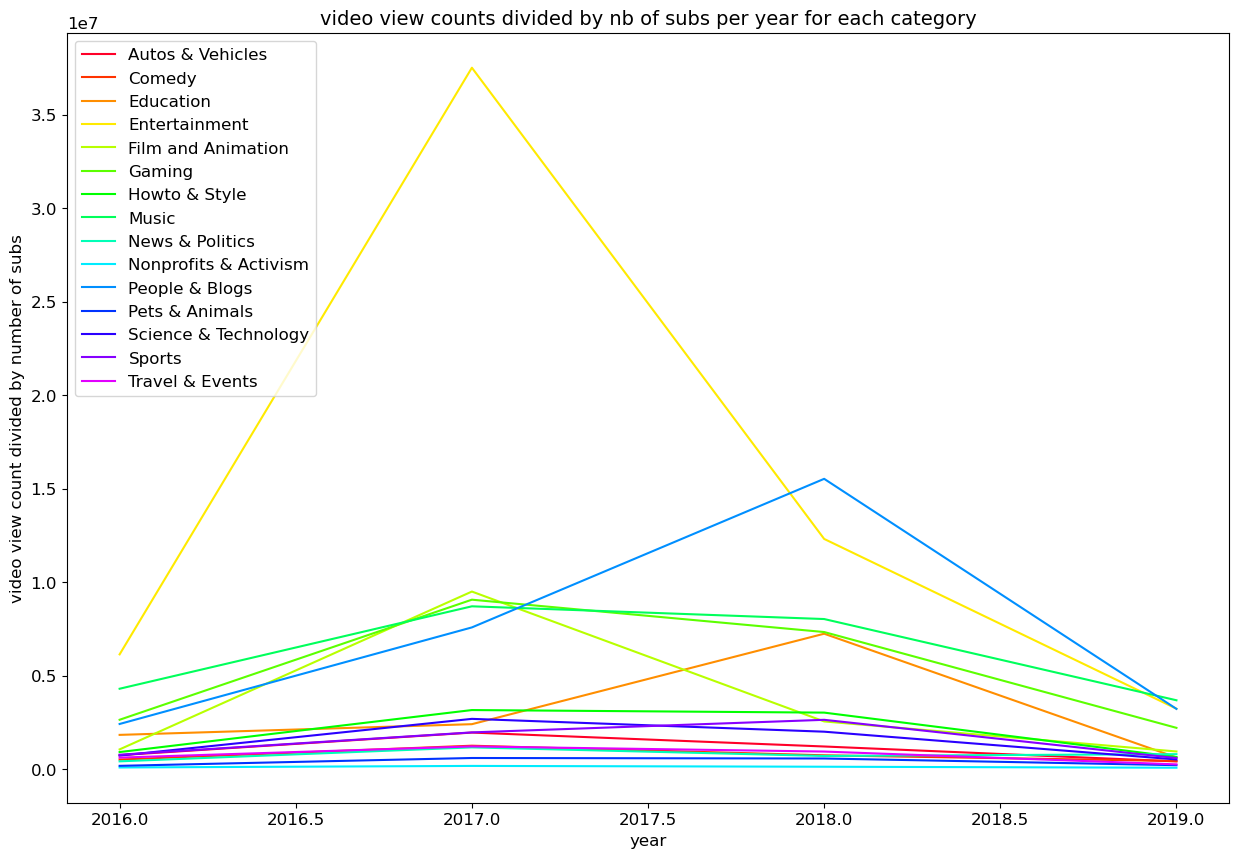

In [63]:
NUM_COLORS = 15
cm = plt.get_cmap('gist_rainbow')
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_prop_cycle(color=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
plt.rcParams["figure.figsize"] = (15, 10)
for i in np.arange(views_over_subs_per_year.shape[0]):
    plt.plot(
        views_over_subs_per_year.loc[
            i,
        ][2:],
        label=views_over_subs_per_year.loc[i,][
            0:1
        ][0],
    )
    
plt.legend(loc="upper left")
plt.xlabel("year")
plt.ylabel("video view count divided by number of subs")
plt.title("video view counts divided by nb of subs per year for each category")
plt.show()

---

# Use Least Square to predict the number of views given the category and the date

In [ ]:
def choose_video_metadata_year(year):
    return video_metadatas[video_metadatas["year"] == year]


In [ ]:
video_metadatas["year"] = video_metadatas["upload_date"].dt.year


In [ ]:
video_metadatas.head()


In [ ]:
video_metadatas.columns


In [ ]:
video_metadatas_2005 = choose_video_metadata_year(2005)
video_metadatas_2005.drop(["upload_date", "channel_id"], axis=1, inplace=True)
video_metadatas_2005.head()


In [ ]:
model = smf.ols(
    formula="view_count ~ duration + C(categories)", data=video_metadatas_2005
)

res = model.fit()
print(res.summary())

# print(res.predict([120, 'Music']))


---

In [ ]:
top_ranked_channels = df_channels[df_channels.subscriber_rank_sb < 100]
top_ranked_channels.head()


In [ ]:
date = top_ranked_channels["join_date"].apply(lambda d: d.to_pydatetime().year)
np.mean(date, axis=0)


In [ ]:
oldest_video = df_channels["join_date"].apply(lambda d: d.to_pydatetime().year)
oldest_video.nsmallest(5)


In [ ]:
channels_with_largest_subscribers = df_channels.nlargest(53, "subscribers_cc")
channels_with_largest_subscribers.sample(7)
